In [101]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import pvlib
from pvlib.pvsystem import *
from pvlib.location import *
from pvlib.modelchain import *

### Declare file paths

In [102]:
PATH_OUT = '../data/input/pv_capacity_factors'

### Define Location

In [103]:
# locational data from the HKW Süd in Leipzig
location = Location(
    latitude=51.2977709091898,
    longitude=12.384516163433474,
    name='Leipzig',
    altitude=113,
    tz='Etc/GMT-1')

### Define Weather

In [104]:
weather = pvlib.iotools.get_pvgis_tmy(
    latitude=location.latitude, 
    longitude=location.longitude)[0]

weather.index.name = "utc_time"

# Replace Test Reference Year timestamps with continuouse timestamps
weather.index = pd.date_range(
    start ="2017-01-01 00:00",
    freq='h',
    periods=8760,
    tz = 'UTC')


### Specify module parameters

In [105]:
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

### Define PV-System

In [106]:
mount = FixedMount(
    surface_tilt=45,
    surface_azimuth=270
)
array = Array(
    mount=mount,
    module_parameters=module,
    temperature_model_parameters=temperature_model_parameters
)
system = PVSystem(
    arrays=[array],
    inverter_parameters=inverter
)
mc = ModelChain(system, location)
mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [107]:
print(mc.results.dc)

                           i_sc  i_mp  v_oc  v_mp  p_mp  i_x  i_xx
2017-01-01 00:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 01:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 02:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 03:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-01-01 04:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
...                         ...   ...   ...   ...   ...  ...   ...
2017-12-31 19:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-12-31 20:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-12-31 21:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-12-31 22:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2017-12-31 23:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0

[8760 rows x 7 columns]


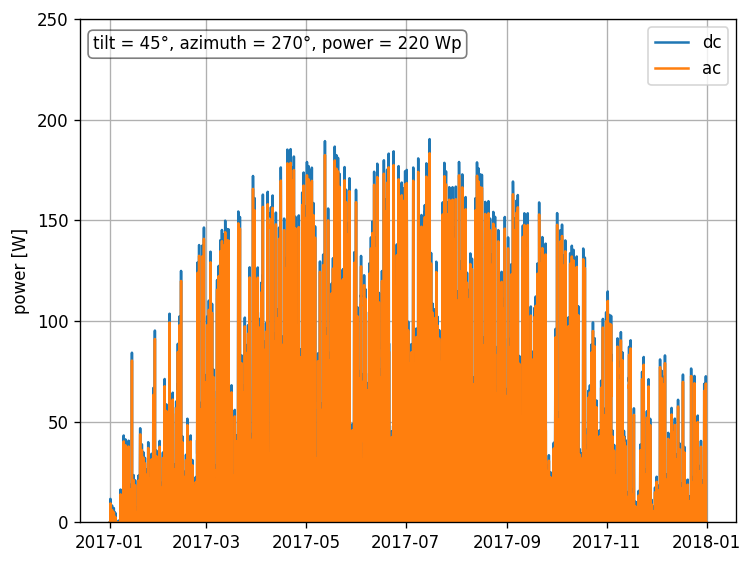

In [108]:
module_power = module.Impo * module.Vmpo

fig, ax = plt.subplots(dpi=120)
plt.plot(mc.results.dc['p_mp'], label='dc')
plt.plot(mc.results.ac, label='ac')
plt.ylabel('power [W]')
plt.ylim(0, 250)
ax.text(
    0.02,
    0.94,
    f'tilt = {mount.surface_tilt}°, azimuth = {mount.surface_azimuth}°, power = {round(module_power)} Wp',
    transform=ax.transAxes,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid()
plt.legend()
fig.tight_layout()

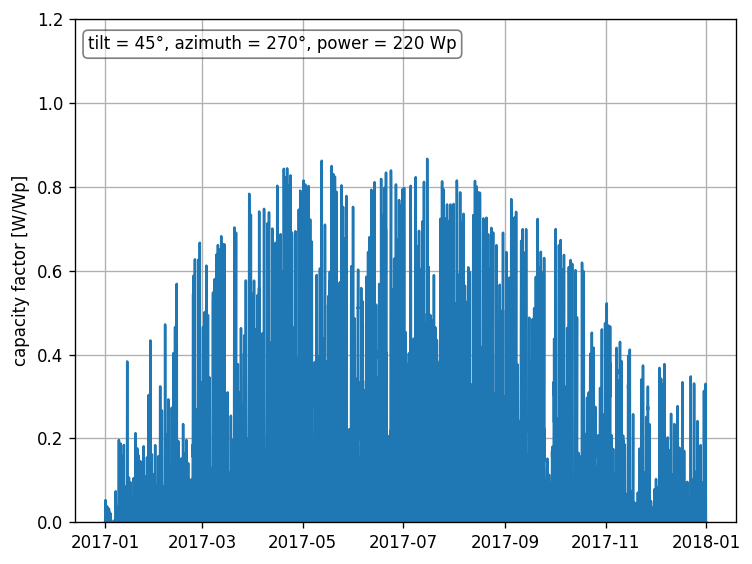

In [109]:
module_power = module.Impo * module.Vmpo

fig, ax = plt.subplots(dpi=120)
plt.plot(mc.results.dc['p_mp'] / module_power)
plt.ylabel('capacity factor [W/Wp]')
plt.ylim(0, 1.2)
ax.text(
    0.02,
    0.94,
    f'tilt = {mount.surface_tilt}°, azimuth = {mount.surface_azimuth}°, power = {round(module_power)} Wp',
    transform=ax.transAxes,
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.grid()
fig.tight_layout()


In [110]:
capacity_factors = pd.DataFrame(
    {'timestamps': mc.results.dc.index,
     'dc_power': mc.results.dc['p_mp'].round(3),
     'capacity_factor': (mc.results.dc['p_mp'] / module_power).round(3)})
capacity_factors.index = range(1, len(capacity_factors) + 1)

if not os.path.exists(PATH_OUT):
    os.makedirs(PATH_OUT)

capacity_factors.to_csv(
    f'{PATH_OUT}/' +
     f'{location.name.lower()}_' + 
     f't{mount.surface_tilt}_' +
     f'a{mount.surface_azimuth}.csv')